# Data analysis of skeletal muscle area and SMI for normal patients

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

###### Load libraries and directories

In [2]:
from IPython.display import display, HTML

In [3]:
# from IPython import get_ipython
from tqdm.notebook import tqdm
import pickle
import os
import pprint
pp = pprint.PrettyPrinter(indent=1)

import pandas as pd
import numpy as np

import json

# Custom functions
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename):        
    with open(filename, 'rb') as input:
        return pickle.load(input)
    

In [4]:
# Install statsmodels if it doesn't exist
def import_or_install(package):
    try:
        return __import__(package)
    except ImportError:
        pip.main(['install', package]) 
        
package = 'statsmodels'

import_or_install(package)

<module 'statsmodels' from '/usr/local/lib/python3.6/dist-packages/statsmodels/__init__.py'>

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.stats as stats

In [6]:
get_ipython().run_line_magic('tb', '')

No traceback available to show.


In [7]:
cwd = os.getcwd()
#print(cwd)
data = '/tf/data'
pickles = '/tf/pickles'
models = '/tf/models'

In [8]:
# Import modules and config file
configfile = os.path.join(cwd,'config/debug_ES/run_prediction_CV.json')
with open(configfile, "r") as f:
        config = json.load(f)
#pp.pprint(config)

## Produce data for analysis using prediction results and preprocessing results

In [9]:
# Load the area csv
sma_csv = os.path.join(config["muscle_segmentor"]["output_directory"],'areas-mm2_by_subject_id.csv')
df_sma = pd.read_csv(sma_csv, index_col=False)
#display(df_sma.head(10))

In [10]:
# change subject_id to id
df_sma.columns=['ID','area_mm2','sagittals','axials']
#display(df_sma.head(2))

In [11]:
# Load the df_final pickle
df_final_d1 = load_object(os.path.join(pickles,'df_final_dump1_processed.pkl'))
#print('dump 1 length = ',len(df_final_d1))
df_final_d2 = load_object(os.path.join(pickles,'df_final_dump2_processed.pkl'))
#print('dump 2 length = ',len(df_final_d2))

In [12]:
# Merge the  2 dumps
df_final = df_final_d1.append(df_final_d2)
#print('Total processed final length = ',len(df_final))

In [13]:
# Create the dataframe for analysis by merging df_sma with df_final
# Replace axial and sagittal series in df_final with df_sma that has 
# pointers to reconstructed sagittals, preserve the other fields.
df_final = df_final.drop(columns=['Axial','Sagittal'])
#display(df_final.head(10))

In [14]:
# Make sure both dfs are equal length
#print('Sma len: ', len(df_sma))
#print('Final len: ', len(df_final))

In [15]:
# 25 cases failed because of L3 level was out of bound, get rid of those for now:
df_final = df_final[df_final['ID'].isin(df_sma['ID'].values)]
print('No of patients processed successfully: ', len(df_final))

No of patients processed successfully:  2367


In [16]:
# Now merge on ID
df_analysis = pd.merge(df_sma,df_final, on="ID")
#display(df_analysis.head(10))

In [17]:
# Load age information from patlist csv
# Load normal patient list
infile  = 'patlist_with_validBMI.csv'
df_P = pd.read_csv(infile, index_col=False)
df_P = df_P.loc[:, ~df_P.columns.str.contains('^Unnamed')]
# Keep only columns needed
df_P = df_P[['PAT_ID','WEIGHT','HEIGHT','BMI_FOR_AGE_PERCENTILE','BMI_CALCULATED','Age',
 'Sex',
 'Race',
 'AgeGroup']]
df_P.columns = ['ID','WEIGHT','HEIGHT','BMI_AGE_P','BMI_CALC','Age','Sex','Race','AgeGroup']
#display(df_P.head(10))

In [18]:
# Get rid of patients not in df_analysis
print("Total number of normal patients identified", len(df_P))
df_P = df_P[df_P['ID'].isin(df_analysis['ID'].values)]

Total number of normal patients identified 2399


In [19]:
# Merge the patient fields with df_analysis
df_analysis = pd.merge(df_P,df_analysis, on="ID")

# Redefine AgeGroup be flooring instead of rounding.
df_analysis['AgeGroup'] = np.floor(df_analysis['Age'].values)

In [20]:
# Find missing BMI_CALC
print('Patients missing BMI calculated:' ,len(df_analysis[df_analysis['BMI_CALC'].isnull()]))
print('Patients missing BMI age percentile:' ,len(df_analysis[df_analysis['BMI_AGE_P'].isnull()]))
print('Patients missing Height:' ,len(df_analysis[df_analysis['HEIGHT'].isnull()]))
print('Patients missing Weight' ,len(df_analysis[df_analysis['WEIGHT'].isnull()]))
print('Patients missing Age' ,len(df_analysis[df_analysis['Age'].isnull()]))
print('Patients missing Race' ,len(df_analysis[df_analysis['Race'].isnull()]))
print('Patients missing Sex' ,len(df_analysis[df_analysis['Sex'].isnull()]))

Patients missing BMI calculated: 263
Patients missing BMI age percentile: 0
Patients missing Height: 17
Patients missing Weight 36
Patients missing Age 0
Patients missing Race 0
Patients missing Sex 0


In [21]:
df_analysis = df_analysis.sort_values(by=['AgeGroup'],ascending='False')
#print(df_analysis['AgeGroup'].value_counts().sort_values())

In [22]:
# Patients > 18
print('No of Patients > 18 years that are discarded' ,len(df_analysis[df_analysis['AgeGroup'] > 18]))
#print('No of Patients < 2.5 yearas' ,len(df_analysis[df_analysis['Age'] < 2.5]))

No of Patients > 18 years that are discarded 1


In [23]:
#print('No of boys' ,len(df_analysis[df_analysis['Sex'] == 'Male']))
#print('No of girls' ,len(df_analysis[df_analysis['Sex'] == 'Female']))

In [24]:
# Create sex stratified and age filtered dfs

df_analysis['area_cm2'] = df_analysis['area_mm2']/100


df_analysis['smi'] = df_analysis['area_cm2']/((df_analysis['HEIGHT']/100)**2)

df_m = df_analysis[(df_analysis['Sex']=='Male') & (df_analysis['AgeGroup'] <= 18)] #& (df_analysis['Age'] > 3)]
print('Length of male df = ',len(df_m))
df_f = df_analysis[(df_analysis['Sex']=='Female') & (df_analysis['AgeGroup'] <= 18)] # & (df_analysis['Age'] > 3)]
print('Length of female df = ',len(df_f))

Length of male df =  1149
Length of female df =  1217


## Population statistics in comparison to CDC/WHO data

In [25]:
#Step3: Loop over each unique date in the studies dataframe df_F
def get_agewise_stats(df_in):
    uniqueages = df_in.AgeGroup.unique() 
    column_names = ['AgeGroup','Age_IQR','median_area_cm2','median_SMI','samplesize']
    df_C = pd.DataFrame(columns = column_names)
    #display(df_C)
    for age in uniqueages:
        df_l = df_in[df_in['AgeGroup']==age]
        #mean_ar = np.mean(df_l['area_cm2'])
        median_ar = np.median(df_l['area_cm2'])
        median_SMI = np.nanmedian(df_l['smi'])
        q75, q25 = np.percentile(df_l['Age'], [75 ,25])
        age_iqr = q75 - q25
        samplesize = len(df_l)
        #print([age,mean_ar,median_ar,samplesize])
        df = pd.DataFrame([[age,age_iqr,median_ar,median_SMI,samplesize]],columns=column_names)
        #display(df)
        df_C = pd.concat([df_C,df])
    return df_C

In [26]:
print('Count statistics stratified by gender and age group')
print('(M - Male) (F-Female)')    
df_f_agestats = get_agewise_stats(df_f).add_suffix('_F')
df_m_agestats = get_agewise_stats(df_m).add_suffix('_M')

display(pd.concat([df_f_agestats,df_m_agestats],axis=1))
#df_f_agestats.to_csv(output+'/Female_summary.csv',index=False)

Count statistics stratified by gender and age group
(M - Male) (F-Female)


,AgeGroup_F,Age_IQR_F,median_area_cm2_F,median_SMI_F,samplesize_F,AgeGroup_M,Age_IQR_M,median_area_cm2_M,median_SMI_M,samplesize_M
0,0.0,0.084796,18.048893,57.687376,6,0.0,0.206801,19.758642,57.931487,11
0,1.0,0.455484,29.221452,41.854235,3,1.0,0.000251,32.792859,47.641699,2
0,2.0,0.428267,33.629887,39.951290,21,2.0,0.484050,35.854305,42.322454,38
0,3.0,0.348162,37.343025,37.848349,24,3.0,0.510209,39.597636,39.847032,45
0,4.0,0.346162,40.355046,34.946658,20,4.0,0.389739,47.455619,38.853210,35
0,5.0,0.561457,46.739722,35.740212,27,5.0,0.493126,49.870643,38.146897,51
0,6.0,0.311717,47.462440,33.859921,44,6.0,0.456702,51.822021,36.992773,56
0,7.0,0.578642,52.024710,33.380896,41,7.0,0.581941,58.329725,36.397572,69
0,8.0,0.618877,56.632868,33.447055,49,8.0,0.430872,62.780000,35.973154,51
0,9.0,0.588487,63.020651,33.327606,58,9.0,0.487839,68.504714,36.250046,49


### Calculate Z-scores for bmi, height and weight w.r.t to age from WHO/CDC data

In [27]:
#pip install pygrowup
from pygrowup import Calculator
from pygrowup import helpers

calculator = Calculator(include_cdc=True)

def percentile_for_zscore(zscore):
    return stats.norm.cdf(zscore)

def zscore_for_percentile(p):
    return stats.norm.ppf(p)

def add_Z_scores(row):
    try:
        global calculator
        valid_age = row['Age']*12
        valid_gender = helpers.get_good_sex(row['Sex'])
        if (np.isnan(row['HEIGHT'])):
            row['height_age_Zscore'] = row["HEIGHT"]
        else:
            row['height_age_Zscore'] = float(calculator.lhfa(row['HEIGHT'],valid_age,valid_gender))
        
        if (np.isnan(row['WEIGHT'])):
            row['weight_age_Zscore'] = row["WEIGHT"]
        else:
            row['weight_age_Zscore'] = float(calculator.wfa(row['WEIGHT'],valid_age,valid_gender))
            
        if (np.isnan(row['BMI_AGE_P'])):
            row['bmi_age_Zscore'] = row['BMI_AGE_P']
        else:
            row['bmi_age_Zscore'] = zscore_for_percentile(row['BMI_AGE_P']/100)
    except:
        print(row)
        raise
    return row


def add_Zpercentile_scores(row):
    try:
        if (np.isnan(row['weight_age_Zscore'])):
            row['weight_age_Zpercentile'] = row["weight_age_Zscore"]
        else:
            row['weight_age_Zpercentile'] = 100*percentile_for_zscore(row["weight_age_Zscore"])
        
        if (np.isnan(row['height_age_Zscore'])):
            row['height_age_Zpercentile'] = row["height_age_Zscore"]
        else:
            row['height_age_Zpercentile'] = 100*percentile_for_zscore(row["height_age_Zscore"])
    except:
        print(row)
        raise
    return row

In [28]:
df_m = df_m.apply(add_Z_scores,axis=1)
df_m = df_m.rename({'BMI_AGE_P':'bmi_age_Zpercentile'},axis=1)
#df_m.weight_age_Zscore = df_m.weight_age_Zscore.astype(float)
#df_m.height_age_Zscore = df_m.height_age_Zscore.astype(float)
#df_m.bmi_age_Zscore = df_m.bmi_age_Zscore.astype(float)
df_m = df_m.apply(add_Zpercentile_scores,axis=1)

In [29]:
df_f = df_f.apply(add_Z_scores,axis=1)
df_f = df_f.rename({'BMI_AGE_P':'bmi_age_Zpercentile'},axis=1)
#df_m.weight_age_Zscore = df_m.weight_age_Zscore.astype(float)
#df_m.height_age_Zscore = df_m.height_age_Zscore.astype(float)
#df_m.bmi_age_Zscore = df_m.bmi_age_Zscore.astype(float)
df_f = df_f.apply(add_Zpercentile_scores,axis=1)

In [30]:
# Compute descriptive statistics on the dataframe
def calculate_stats(df):
    num_list = ['BMI_CALC','WEIGHT','HEIGHT','Age','area_cm2','smi','height_age_Zscore','height_age_Zpercentile',
                'weight_age_Zscore','weight_age_Zpercentile','bmi_age_Zscore','bmi_age_Zpercentile']
    df_num = df[num_list]
    df_d = df_num.describe()
    df_whites = df.loc[df['Race']=='White',num_list].describe()
    df_blacks = df.loc[df['Race']=='Black or African American',num_list].describe()
    df_others = df.loc[(df['Race']!='Black or African American') & (df['Race']!='White'),num_list].describe()
    
    df_whites = df_whites.add_suffix('_W')
    df_blacks = df_blacks.add_suffix('_B')
    df_others = df_others.add_suffix('_O')
    return pd.concat([df_d, df_whites,df_blacks,df_others], axis=1)

In [31]:
df_m_stats= calculate_stats(df_m).T.round(decimals=2)
df_f_stats = calculate_stats(df_f).T.round(decimals=2)

In [32]:
print("Population Statistics for Male")
display(df_m_stats.head(12))

Population Statistics for Male


,count,mean,std,min,25%,50%,75%,max
BMI_CALC,1001.0,18.99,3.19,13.59,16.45,18.45,21.17,31.02
WEIGHT,1126.0,44.78,20.82,3.80,26.50,43.00,61.90,99.00
HEIGHT,1141.0,147.29,28.09,49.00,127.00,151.00,171.00,205.74
Age,1149.0,11.36,4.58,0.07,7.79,12.07,15.22,18.90
area_cm2,1149.0,91.87,40.90,0.00,58.44,84.40,124.74,208.36
smi,1141.0,40.40,7.79,0.00,35.58,39.98,45.39,77.81
height_age_Zscore,1141.0,0.27,1.20,-5.62,-0.48,0.28,0.99,4.93
height_age_Zpercentile,1141.0,57.19,30.37,0.00,31.56,61.03,83.89,100.00
weight_age_Zscore,1126.0,0.36,0.95,-7.34,-0.24,0.42,1.02,2.85
weight_age_Zpercentile,1126.0,61.28,27.10,0.00,40.52,66.28,84.61,99.78


In [33]:
print("Population Statistics for Female")
display(df_f_stats.head(12))

Population Statistics for Female


,count,mean,std,min,25%,50%,75%,max
BMI_CALC,1102.0,20.43,3.74,11.64,17.38,20.20,23.14,30.32
WEIGHT,1204.0,48.42,17.49,4.27,35.00,51.75,62.00,89.00
HEIGHT,1208.0,149.69,21.52,47.00,140.23,157.00,164.00,191.00
Age,1217.0,12.90,4.22,0.09,10.15,14.05,16.17,18.94
area_cm2,1217.0,83.40,25.66,0.27,64.98,87.10,102.25,164.61
smi,1208.0,36.57,6.47,0.09,32.72,35.96,40.08,111.03
height_age_Zscore,1208.0,0.12,1.15,-7.65,-0.58,0.13,0.83,5.00
height_age_Zpercentile,1208.0,53.67,30.06,0.00,28.01,55.17,79.67,100.00
weight_age_Zscore,1204.0,0.40,0.87,-3.91,-0.11,0.52,1.04,2.37
weight_age_Zpercentile,1204.0,63.39,25.74,0.00,45.62,69.85,85.08,99.11


## Correlation metrics

In [34]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    # https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 9)
    return pvalues

In [35]:
print('Correlation Map Male')
display(df_m[['WEIGHT','HEIGHT','Age','BMI_CALC','bmi_age_Zpercentile','area_cm2','smi']].corr().round(3))

Correlation Map Male


,WEIGHT,HEIGHT,Age,BMI_CALC,bmi_age_Zpercentile,area_cm2,smi
WEIGHT,1.000,0.934,0.912,0.846,0.164,0.918,0.308
HEIGHT,0.934,1.000,0.951,0.667,-0.003,0.879,0.139
Age,0.912,0.951,1.000,0.690,-0.045,0.868,0.210
BMI_CALC,0.846,0.667,0.690,1.000,0.544,0.762,0.446
bmi_age_Zpercentile,0.164,-0.003,-0.045,0.544,1.000,0.120,0.273
area_cm2,0.918,0.879,0.868,0.762,0.120,1.000,0.567
smi,0.308,0.139,0.210,0.446,0.273,0.567,1.000


In [36]:
print('P-values for Correlation map - male, P < 0.05 are statistically significant')
display(calculate_pvalues(df_m[['WEIGHT','HEIGHT','Age','BMI_CALC','area_cm2','smi']]))

P-values for Correlation map - male, P < 0.05 are statistically significant


,WEIGHT,HEIGHT,Age,BMI_CALC,area_cm2,smi
WEIGHT,0,0,0,0,0,0
HEIGHT,0,0,0,0,0,0.0002185
Age,0,0,0,0,0,4e-09
BMI_CALC,0,0,0,0,0,0
area_cm2,0,0,0,0,0,0
smi,0,0.0002185,4e-09,0,0,0


In [37]:
print('Correlation Map Female')
display(df_f[['WEIGHT','HEIGHT','Age','BMI_CALC','area_cm2','smi']].corr().round(3))

Correlation Map Female


,WEIGHT,HEIGHT,Age,BMI_CALC,area_cm2,smi
WEIGHT,1.000,0.891,0.868,0.862,0.866,0.141
HEIGHT,0.891,1.000,0.893,0.593,0.831,-0.089
Age,0.868,0.893,1.000,0.673,0.803,0.048
BMI_CALC,0.862,0.593,0.673,1.000,0.705,0.334
area_cm2,0.866,0.831,0.803,0.705,1.000,0.445
smi,0.141,-0.089,0.048,0.334,0.445,1.000


In [38]:
print('P-values for Correlation map - female, P < 0.05 are statistically significant')
display(calculate_pvalues(df_f[['WEIGHT','HEIGHT','Age','BMI_CALC','area_cm2','smi']]))

P-values for Correlation map - female, P < 0.05 are statistically significant


,WEIGHT,HEIGHT,Age,BMI_CALC,area_cm2,smi
WEIGHT,0,0,0,0,0,3.5716e-05
HEIGHT,0,0,0,0,0,0.000524181
Age,0,0,0,0,0,0.312212
BMI_CALC,0,0,0,0,0,0
area_cm2,0,0,0,0,0,0
smi,3.5716e-05,0.000524181,0.312212,0,0,0


## Quantile Regression with Splines

In [39]:
# Get Restricted Cubic splines by transforming independent variable (age)
from statsmodels.regression.quantile_regression import QuantReg as QR
# Reference: 
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from math import sqrt

In [40]:
def calculate_aic(model):
    # https://www.scribbr.com/statistics/akaike-information-criterion/
    K = model.df_model + 2
    L = sum(abs(model.resid))/model.nobs# For q=0.5, this should work! verify later using R
    AIC = 2*K - 2*np.log(L)
    return AIC,L

def get_knots(x,nknots):
    # Knot locations are set based on this article
    #https://support.sas.com/resources/papers/proceedings16/5621-2016.pdf
    if nknots == 3:
        return str((x.quantile(0.1),x.quantile(0.5),x.quantile(0.9)))
    elif nknots == 4:
        return str((x.quantile(0.05),x.quantile(0.35),x.quantile(0.65),x.quantile(0.95)))
    elif nknots == 5:
        return str((x.quantile(0.05),x.quantile(0.275),x.quantile(0.5),x.quantile(0.725),x.quantile(0.95)))

def spline_model_optimizer(df,response_var,predictor_var='Age',degrees=[1,2,3],nknots=[3,4,5]):
    # Storage parameters
    model_dict = {}
    akaike_dict = {}
    aic_dict = {}
    L_dict = {}
    knots_dict = {} 
    degrees_dict = {}
    model_keys = []
    
    # Knot constraints
    min_knot = 3
    max_knot = 15 + 1 # [+1 for python]
    min_knot_diff = 3
    
    # Iterate over all knots
    model_count = 0
    for knot in nknots :
        knots = get_knots(np.floor(df[predictor_var]),knot)
        # Iterate over all polynomial degrees
        for deg in degrees:
            # Book-keeping
            model_count += 1
            mkey = 'm'+ str(model_count)
            model_keys.append(mkey)
            knots_dict[mkey] = knots
            degrees_dict[mkey] = deg
            
            # Transformed input for splines
            transformed_age = dmatrix("bs(train, knots=" + knots + ", degree=" + str(deg) + 
                                      ", include_intercept=False)",
                                      {"train": df[predictor_var].values},return_type='dataframe')
            
            # Fit qr model
            qr_model = QR(df[response_var].values,transformed_age.values)
            fit_qr_mid = qr_model.fit(q=0.50)
            
            # Fit GLM model
            fit_glm = sm.GLM(df[response_var].values,transformed_age.values).fit()
            
            model_dict[mkey] = qr_model
            
            # Get AIC
            akaike_dict[mkey], L_dict[mkey] = calculate_aic(fit_qr_mid)
             
            # Get aic of GLM model
            aic_dict[mkey] = fit_glm.aic
            
    # Find best model
    best_model = min(akaike_dict, key=akaike_dict.get)
    
    # for debug
    # return model_dict,aic_dict,akaike_dict,L_dict,knots_dict,degrees_dict,model_keys,best_model
    return model_dict[best_model],knots_dict[best_model],degrees_dict[best_model]

In [41]:
def fit_bs_models(model,qlist):
    res = [model.fit(q=q) for q in qlist] 
    return res


def get_transformed_x(x,knots,degrees):
    transformed_x = dmatrix("bs(train, knots=" + knots +", degree= "+ str(degrees) 
                    +",include_intercept=False)", {"train": x},return_type='dataframe')
    return transformed_x


def find_points_above(model,x_data,y_data):
    y_m = model.predict(x_data)
    points = y_data > y_m
    outlier_count = sum(points)
    return outlier_count, points

def find_points_below(model,x_data,y_data):
    y_m = model.predict(x_data)
    points = y_data < y_m
    outlier_count = sum(points)
    return outlier_count, points

def plot_bs_qr(dfs,mlist,knots,degrees,sexes=['male','female'],predictor='Age',response='area_cm2'):
    x = np.linspace(dfs[0][predictor].values.min(),dfs[0][predictor].values.max(),70)
    ymax = max(max(dfs[0][response]),max(dfs[0][response]))
    plt.figure(figsize = (14,7),linewidth=2)
    
        #fig, ax = plt.subplots(figsize=(8, 6))
    for n in range(len(mlist)):
        df = dfs[n]
        models = mlist[n]
        
        transformed_x = dmatrix("bs(train, knots=" + knots[n] +", degree= "+ str(degrees[n]) 
                                +",include_intercept=False)",
                                {"train": x},return_type='dataframe')
        
        ax = plt.subplot(1,2,n+1)
        for i in range(len(models)):
            y = models[i].predict(transformed_x)
            ax.plot(x, y, linestyle='dotted',label='q =' + str(round(models[i].q,2)),linewidth=3)
          
        
        # Plot outliers in red
        x_data = df[predictor].values
        tr_x_data = get_transformed_x(x_data,knots[n],degrees[n])
        y_data = df[response].values
        _,outliers_above = find_points_above(models[-1],tr_x_data,y_data)
        _,outliers_below = find_points_below(models[0],tr_x_data,y_data)
       # print('Number of outliers > 0.90: ', sum(outliers_above))
       # print('Number of outliers < 0.10: ', sum(outliers_below))
        outliers = outliers_above | outliers_below
        print('Total outliers: ', sum(outliers), 'Total points: ', len(outliers))
        normals = ~ outliers
        ax.scatter(x_data[normals], y_data[normals],facecolor=None, edgecolor = 'k', alpha=.05)
        ax.scatter(x_data[outliers], y_data[outliers],facecolor=None, edgecolor = 'r', alpha=.25)
        
       #ax.scatter(df[predictor], df[response],facecolor=None, edgecolor = 'k', alpha=.1)
       # print(np.ceil(max(df[predictor].values)))
        ax.set_xlim((0, np.ceil(max(df[predictor].values))),auto=True)
        ax.set_ylim(0, ymax,auto=True)
        legend = ax.legend()
        if np.ceil(max(df[predictor].values)) > 20:
            xtick_r = 20
        else:
            xtick_r = 1
        
        ax.set_xticks(np.arange(0,np.ceil(max(df[predictor].values)),xtick_r))
        
        if predictor == "BMI_CALC":
            ax.set_xlim(10, np.ceil(max(df[predictor].values)),auto=True)
            xtick_r = 2
            ax.set_xticks(np.arange(10,np.ceil(max(df[predictor].values)),xtick_r))
        
        ax.set_yticks(np.arange(0,ymax,20))
        ax.set_xlabel(predictor, fontsize=16)
        ax.set_ylabel(response, fontsize=16)
        ax.set_title(sexes[n])
        
        
def plot_bs_qr_wcdc(dfs,mlist,knots,degrees,cdc_df,sexes=['male','female'],predictor='Age',response='area_cm2'):
    x = np.linspace(dfs[0][predictor].values.min(),dfs[0][predictor].values.max(),70)
    ymax = max(max(dfs[0][response]),max(dfs[0][response]))
    plt.figure(figsize = (14,7),linewidth=2)
    
    colors = ['r','g','c','m','b']
    #fig, ax = plt.subplots(figsize=(8, 6))
    for n in range(len(mlist)):
        df = dfs[n]
        models = mlist[n]
        
        cdc_df_sex = cdc_df[cdc_df['Sex']==n+1]
        
        transformed_x = dmatrix("bs(train, knots=" + knots[n] +", degree= "+ str(degrees[n]) 
                                +",include_intercept=False)",
                                {"train": x},return_type='dataframe')
        
        ax = plt.subplot(1,2,n+1)
        for i in range(len(models)):
            y = models[i].predict(transformed_x)
            ax.plot(x, y, linestyle='dotted',color=colors[i],label='q =' + str(round(models[i].q,2)),linewidth=3)
            ax.plot(cdc_df_sex.iloc[:,1],cdc_df_sex.iloc[:,i+2],color=colors[i],label='cdc, q =' + str(round(models[i].q,2)),linewidth=2)

        ax.scatter(df[predictor], df[response],facecolor=None, edgecolor = 'k', alpha=.1)
        ax.set_xlim((0, np.ceil(max(df[predictor].values))))
        ax.set_ylim(0, ymax,auto=True)
        legend = ax.legend()
        if np.ceil(max(df[predictor].values)) > 20:
            xtick_r = 20
        else:
            xtick_r = 1
        ax.set_xticks(np.arange(0,np.ceil(max(df[predictor].values)),xtick_r))
        ax.set_yticks(np.arange(0,ymax,10))
        ax.set_xlabel(predictor, fontsize=16)
        ax.set_ylabel(response, fontsize=16)
        ax.set_title(sexes[n])

In [42]:
# Import cdc data
# 2 to 20years
infile  = '/tf/smipipeline/growth_curves/data/csv/wtage220.csv'
df_cdc_wt= pd.read_csv(infile, index_col=False)
df_cdc_wt['Age'] = df_cdc_wt['Agemos']/12
df_cdc_wt = df_cdc_wt[['Sex','Age','P10','P25','P50','P75','P90']]

# infants to 3 years
infile2  = '/tf/smipipeline/growth_curves/data/csv/wtageinf.csv'
df_cdc_wt2= pd.read_csv(infile2, index_col=False)
df_cdc_wt2['Age'] = df_cdc_wt2['Agemos']/12
df_cdc_wt2 = df_cdc_wt2[['Sex','Age','P10','P25','P50','P75','P90']]

# keep only till 2 years
df_cdc_wt2 = df_cdc_wt2[df_cdc_wt2['Age']<2]

# Merge
df_cdc_wt = pd.concat([df_cdc_wt,df_cdc_wt2],ignore_index=True)
df_cdc_wt = df_cdc_wt.sort_values(by=['Age'])

response='WEIGHT'
cdc_df = df_cdc_wt
# Get optimal model config
df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response)


# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Population comparison to cdc data on WEIGHT using quantile regression


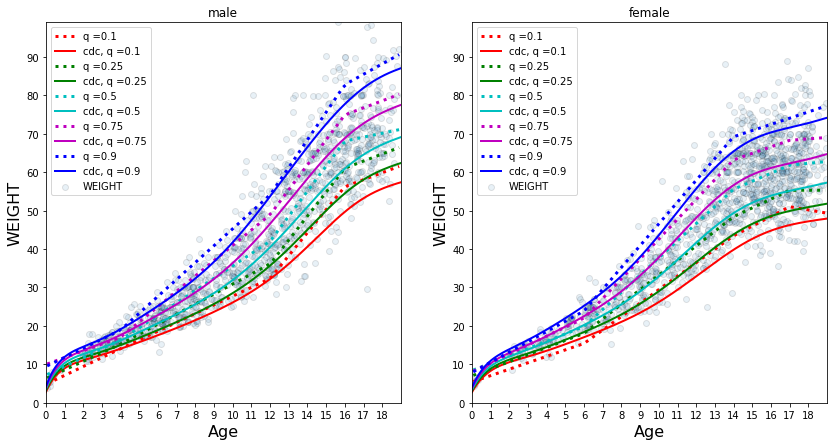

In [43]:
# Plot the results
print('Population comparison to cdc data on ' + response + ' using quantile regression')
plot_bs_qr_wcdc([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           cdc_df = cdc_df,
           response=response)

In [44]:
# Import cdc data
# 2 to 20years
infile  = '/tf/smipipeline/growth_curves/data/csv/statage220.csv'
df_cdc_wt= pd.read_csv(infile, index_col=False)
df_cdc_wt['Age'] = df_cdc_wt['Agemos']/12
df_cdc_wt = df_cdc_wt[['Sex','Age','P10','P25','P50','P75','P90']]
# infants to 3 years
infile2  = '/tf/smipipeline/growth_curves/data/csv/lenageinf.csv'
df_cdc_wt2= pd.read_csv(infile2, index_col=False)
df_cdc_wt2['Age'] = df_cdc_wt2['Agemos']/12
df_cdc_wt2 = df_cdc_wt2[['Sex','Age','P10','P25','P50','P75','P90']]

# keep only till 2 years
df_cdc_wt2 = df_cdc_wt2[df_cdc_wt2['Age']<2]

# Merge
df_cdc_wt = pd.concat([df_cdc_wt,df_cdc_wt2],ignore_index=True)
df_cdc_wt = df_cdc_wt.sort_values(by=['Age'])

response='HEIGHT'
cdc_df = df_cdc_wt
# Get optimal model config
df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response)


# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

Population comparison to cdc data on HEIGHT using quantile regression


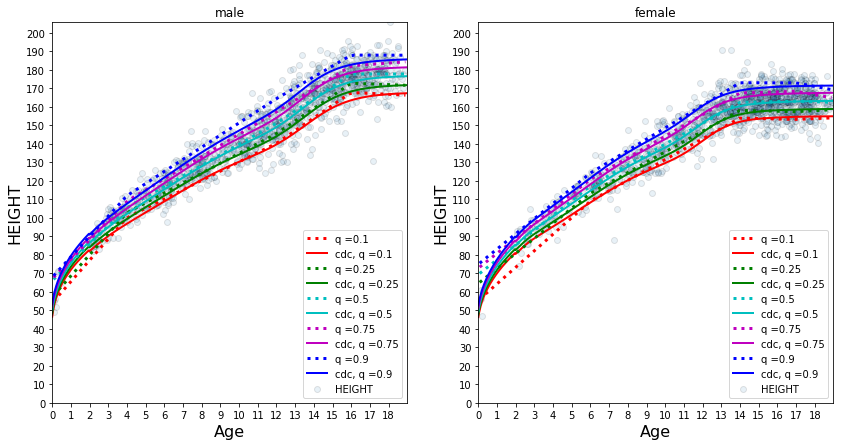

In [45]:
# Plot the results
if cdc_df is not None:
    print('Population comparison to cdc data on ' + response + ' using quantile regression')
    plot_bs_qr_wcdc([df_m_nonull,df_f_nonull],
               [fit_models_m,fit_models_f],
               knots=[knots_m,knots_f],
               degrees=[degrees_m,degrees_f],
               cdc_df = cdc_df,
               response=response)

In [46]:
# Import cdc data
# 2 to 20years
infile  = '/tf/smipipeline/growth_curves/data/csv/bmiage220.csv'
df_cdc_wt= pd.read_csv(infile, index_col=False)
df_cdc_wt['Age'] = df_cdc_wt['Agemos']/12
df_cdc_wt = df_cdc_wt[['Sex','Age','P10','P25','P50','P75','P90']]

response='BMI_CALC'
cdc_df = df_cdc_wt
# Get optimal model config
df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response)


# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

Population comparison to cdc data on BMI_CALC using quantile regression


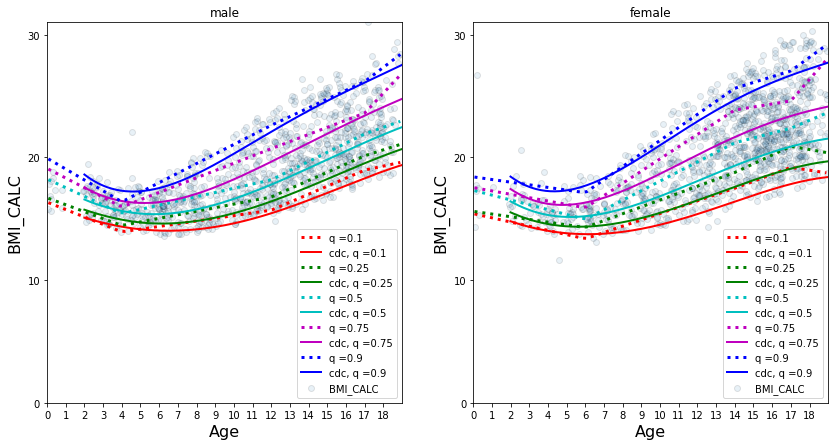

In [47]:
# Plot the results
if cdc_df is not None:
    print('Population comparison to cdc data on ' + response + ' using quantile regression')
    plot_bs_qr_wcdc([df_m_nonull,df_f_nonull],
               [fit_models_m,fit_models_f],
               knots=[knots_m,knots_f],
               degrees=[degrees_m,degrees_f],
               cdc_df = cdc_df,
               response=response)

In [48]:
response='area_cm2'

# Get optimal model config
model_m,knots_m,degrees_m = spline_model_optimizer(df_m, response)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f, response)


# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Quantile Regression with Splines for Skeletal Muscle Area (CCHMC data)
Total outliers:  233 Total points:  1149
Total outliers:  248 Total points:  1217


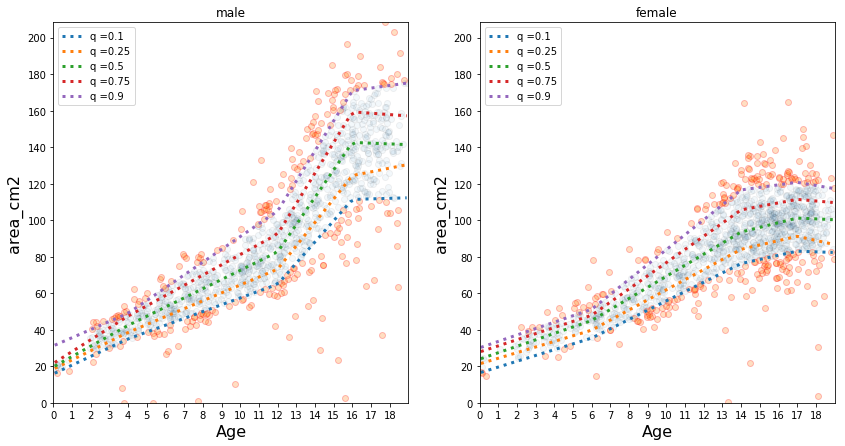

In [49]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Area (CCHMC data)')
plot_bs_qr([df_m,df_f],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           response=response)

In [50]:
import cv2
def show_figures(figlist,titlist):
    plt.figure(figsize = (15,8))
    for n in range(len(figlist)):
        im = cv2.imread(figlist[n])
        im_resized = cv2.resize(im, (1024, 1024), interpolation=cv2.INTER_LINEAR)
        ax = plt.subplot(1,2,n+1)
        ax.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
        ax.set_title(titlist[n])
        ax.axis('off')

Psoas Muscle Results from Metzger.et.al


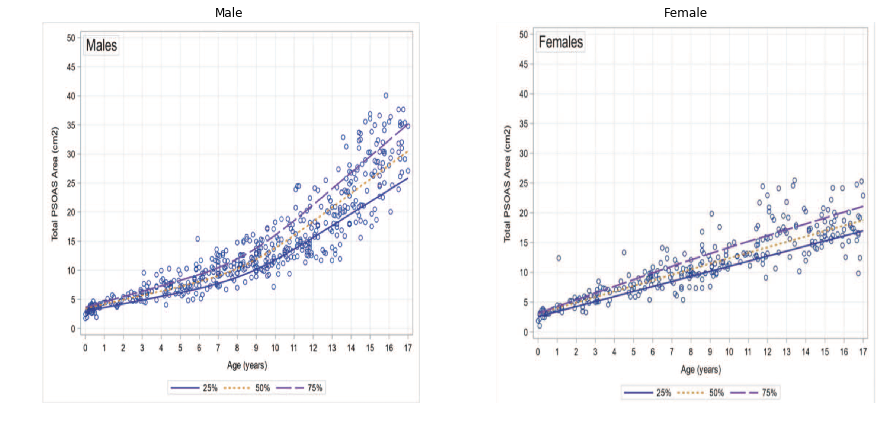

In [51]:
print("Psoas Muscle Results from Metzger.et.al")
f1  = '/tf/smipipeline/growth_curves/data/PMA Metzger Male.png'
f2  = '/tf/smipipeline/growth_curves/data/PMA Metzger Female.png'

show_figures([f1,f2],['Male','Female'])

Psoas Muscle Results from Lurz.et.al


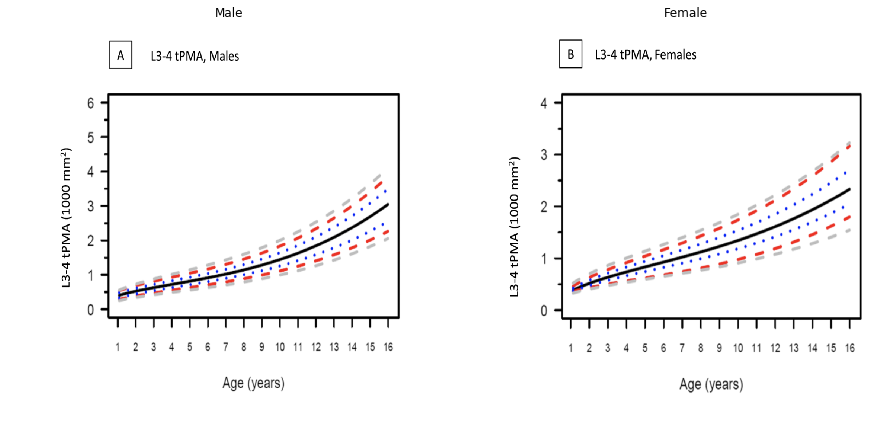

In [52]:
print("Psoas Muscle Results from Lurz.et.al")
f1  = '/tf/smipipeline/growth_curves/data/Lurz PMA male.png'
f2  = '/tf/smipipeline/growth_curves/data/Lurtz PMA female.png'

show_figures([f1,f2],['Male','Female'])

In [53]:
response='smi'


df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])

# Get optimal model config
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response)



# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Quantile Regression with Splines for SMI [CCHMC data]
Total outliers:  233 Total points:  1141
Total outliers:  245 Total points:  1208


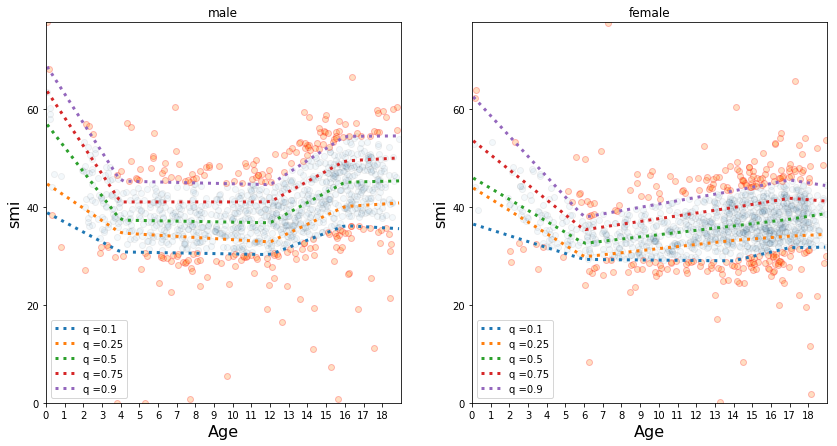

In [54]:
# Plot the results
print('Quantile Regression with Splines for SMI [CCHMC data]')
plot_bs_qr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           response=response)

Psoas Muscle Index Results from Metzger.et.al


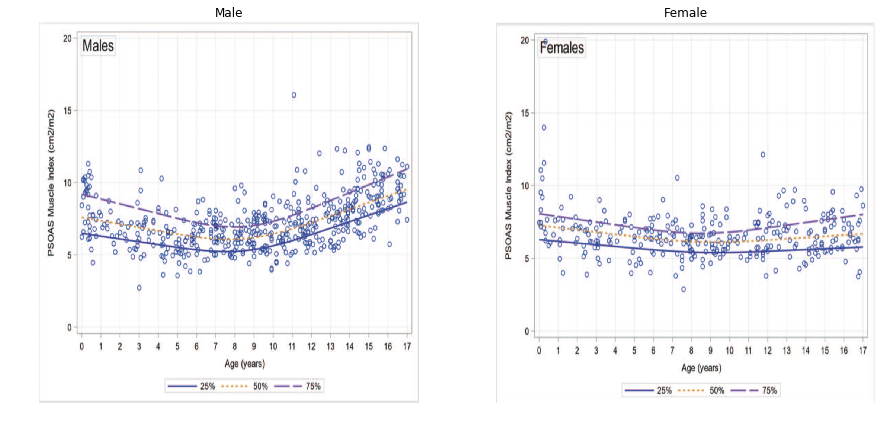

In [55]:
print("Psoas Muscle Index Results from Metzger.et.al")
f1  = '/tf/smipipeline/growth_curves/data/Metzger et al pmi male.png'
f2  = '/tf/smipipeline/growth_curves/data/Metzger et al pmi female.png'

show_figures([f1,f2],['Male','Female'])

In [56]:
response='area_cm2'
predictor='WEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response,predictor_var=predictor)



# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Quantile Regression with Splines for SMA [CCHMC data] vs Weight
Total outliers:  229 Total points:  1126
Total outliers:  244 Total points:  1204


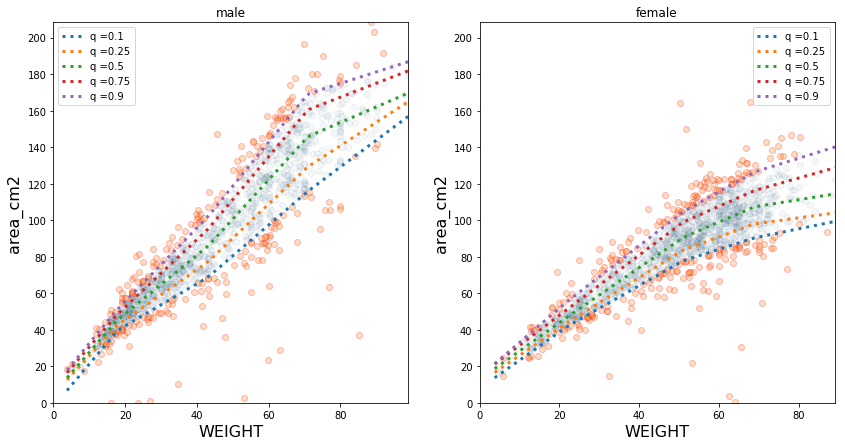

In [57]:
# Plot the results
print('Quantile Regression with Splines for SMA [CCHMC data] vs Weight')
plot_bs_qr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           response=response,predictor=predictor)

In [58]:
response='smi'
predictor='WEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response,predictor_var=predictor)



# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Quantile Regression with Splines for SMI [CCHMC data] vs Weight
Total outliers:  230 Total points:  1123
Total outliers:  245 Total points:  1200


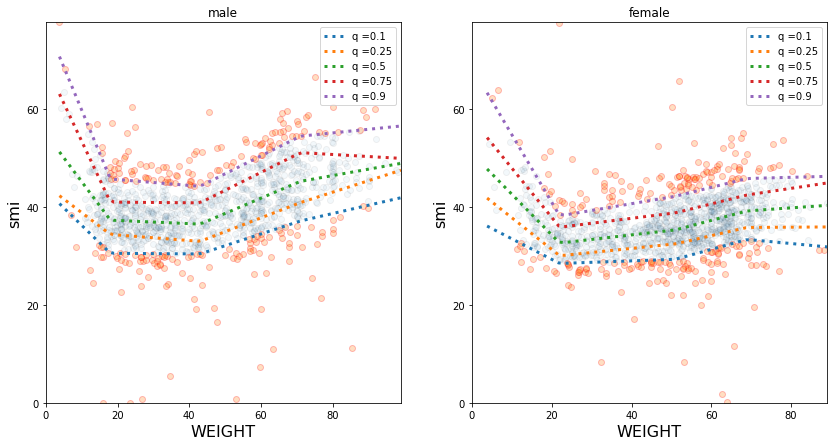

In [59]:
# Plot the results
print('Quantile Regression with Splines for SMI [CCHMC data] vs Weight')
plot_bs_qr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           response=response,predictor=predictor)

In [60]:
response='area_cm2'
predictor='HEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response,predictor_var=predictor)



# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Quantile Regression with Splines for SMA [CCHMC data] vs HEIGHT
Total outliers:  231 Total points:  1141
Total outliers:  245 Total points:  1208


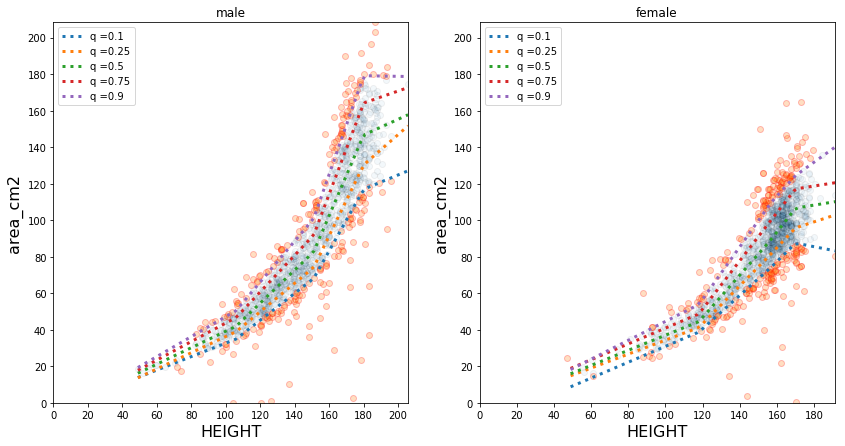

In [61]:
# Plot the results
print('Quantile Regression with Splines for SMA [CCHMC data] vs HEIGHT')
plot_bs_qr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           response=response,predictor=predictor)

In [62]:
response='smi'
predictor='HEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response,predictor_var=predictor)



# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Quantile Regression with Splines for SMI [CCHMC data] vs HEIGHT
Total outliers:  231 Total points:  1141
Total outliers:  245 Total points:  1208


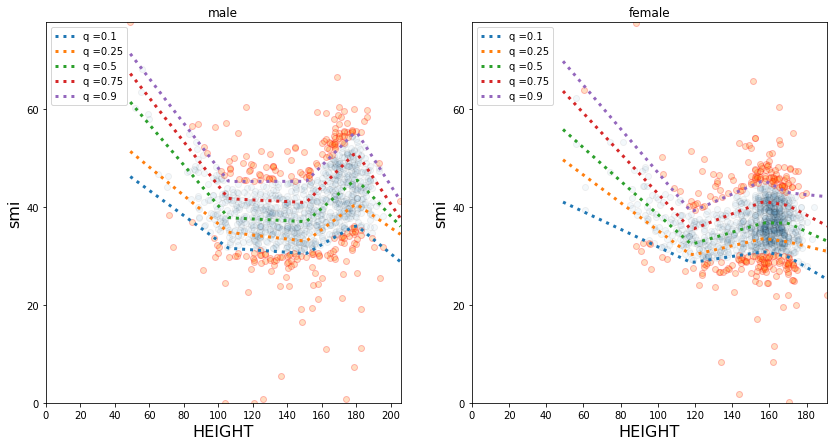

In [63]:
# Plot the results
print('Quantile Regression with Splines for SMI [CCHMC data] vs HEIGHT')
plot_bs_qr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           response=response,predictor=predictor)

In [64]:
response='area_cm2'
predictor='bmi_age_Zpercentile'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response,predictor_var=predictor)



# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Quantile Regression with Splines for SMA [CCHMC data] vs BMI percentile
Total outliers:  233 Total points:  1149
Total outliers:  249 Total points:  1217


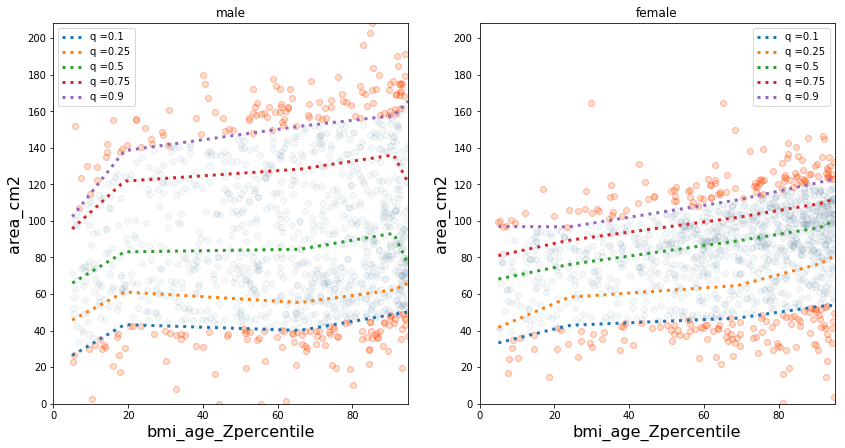

In [65]:
# Plot the results
print('Quantile Regression with Splines for SMA [CCHMC data] vs BMI percentile')
plot_bs_qr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           response=response,predictor=predictor)

In [66]:
response='smi'
predictor='bmi_age_Zpercentile'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response,predictor_var=predictor)



# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Quantile Regression with Splines for SMI [CCHMC data] vs BMI percentile
Total outliers:  233 Total points:  1141
Total outliers:  246 Total points:  1208


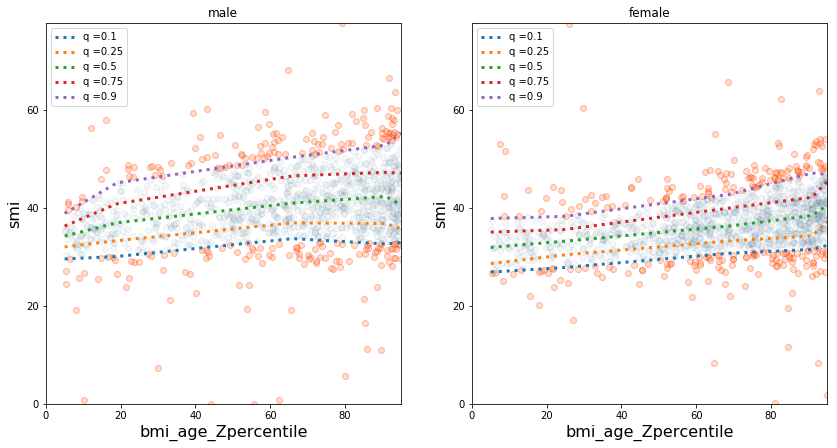

In [67]:
# Plot the results
print('Quantile Regression with Splines for SMI [CCHMC data] vs BMI percentile')
plot_bs_qr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           response=response,predictor=predictor)

In [68]:
response='area_cm2'
predictor='BMI_CALC'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response,predictor_var=predictor)


# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs BMI
Total outliers:  204 Total points:  1001
Total outliers:  223 Total points:  1102


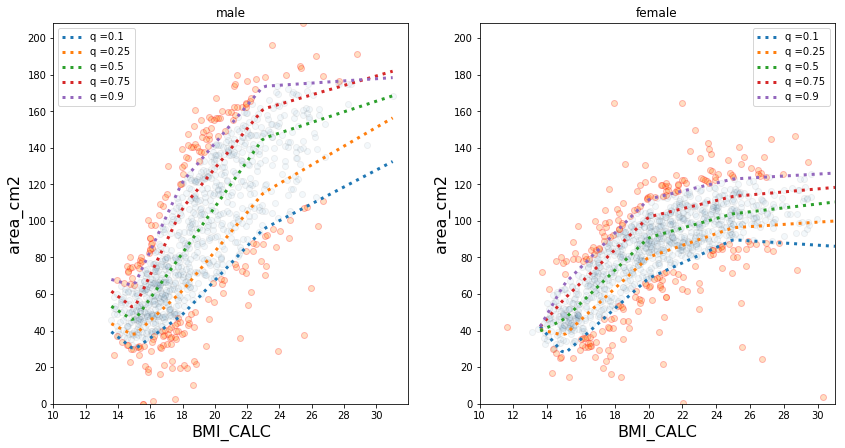

In [69]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs BMI')
plot_bs_qr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           response=response,predictor=predictor)

In [70]:
response='smi'
predictor='BMI_CALC'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response,predictor_var=predictor)



# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs BMI
Total outliers:  202 Total points:  996
Total outliers:  223 Total points:  1094


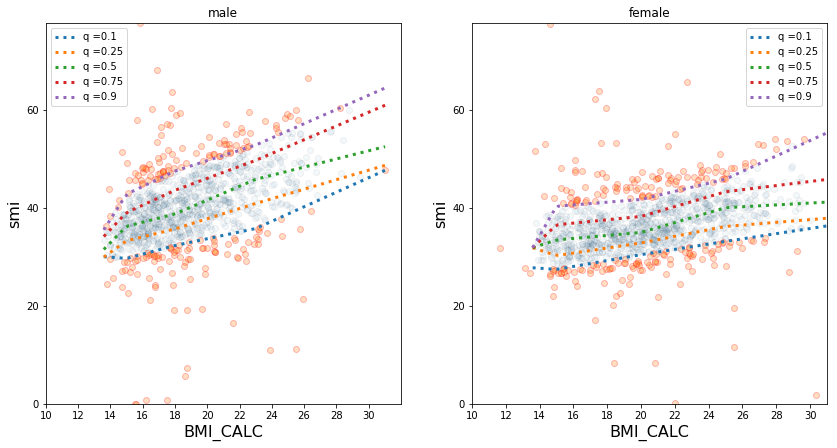

In [71]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs BMI')
plot_bs_qr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           response=response,predictor=predictor)